# Статистический анализ данных GoFast

Целью статистического анализа данных является проверка некоторых гипотез, которые могут помочь вырасти сервису аренды самокатов GoFast.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.
Сервисом можно пользоваться:
* без подписки:
    +  абонентская плата отсутствует; стоимость одной минуты поездки — 8 рублей;
    +  стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

В основных данных есть информация о пользователях, их поездках и подписках.

***План исследования***:
1) [Загрузка данных.](#load)

2) [Предобработка данных.](#process)

3) [Исследовательский анализ данных.](#analysis)

4) [Объединение данных.](#merge)

5) [Подсчёт выручки.](#revenue)

6) [Проверка гипотез.](#hypothesis)

7) [Оценка распределений для проведения акций.](#distibution)

8) [Общий вывод.](#conclusion)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from math import factorial
from math import sqrt
import warnings


### Шаг 1. Загрузка данных
<a id='load'></a>

In [2]:
# Считывание данных и сохранение в датафреймы
users = pd.read_csv('A:/Python/Dataset/users_go.csv')
rides = pd.read_csv('A:/Python/Dataset/rides_go.csv')
subscriptions = pd.read_csv('A:/Python/Dataset/subscriptions_go.csv')

In [3]:
# Обзор данных
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Данные о пользователях, поездках пользователей и о подписках сохранены в 3 датафреймах соответственно: users, rides, subscriptions.
Во всех датафреймах количество ненулевых записей во всех столбцах одинаковое - пропусков нет, типы данных соответстуют везде, кроме стобца с датой в таблице с поездками: object вместо datetime.
Столбцы названы корректно, единообразно.

### Шаг 2. Предобработка данных\
<a id='process'></a>

In [9]:
# Приведение данных с датой к соответствующему формату
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
# Создание столбца номера месяца
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [11]:
# Проверим, за какой период предоставлены данные
rides['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

Данные предоставлены за 2021 год (без 31 декабря).

In [12]:
# Проверка пропущенных значений
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков данных нет.

In [15]:
# Проверка дубликатов

In [16]:
users['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

In [17]:
users['user_id'].duplicated().sum()

31

In [18]:
users = users.drop_duplicates()
users['user_id'].duplicated().sum()

0

In [19]:
users['name'].value_counts()

Мария        22
Анна         22
Дмитрий      17
Александр    17
Никита       16
             ..
Сергей        3
Семен         2
Тихон         1
Радмир        1
Милана        1
Name: name, Length: 194, dtype: int64

In [20]:
rides['user_id'].duplicated().sum()

16534

In [21]:
rides = rides.drop_duplicates()
rides['user_id'].duplicated().sum()

16534

Проведена предобработка данных. Установлено отсутствие пропусков данных. Значения user_id в таблице rides могут повторяться, так как один и тот же пользователь может совершать неограниченное количество поездок. Но в таблице с данными о пользователях users этот параметр должен быть уникален, поэтому 31 дубликат был удален. Остальные данные без дубликатов в едином формате (без опечаток).

### Шаг 3. Исследовательский анализ данных
<a id='analysis'></a>

#### Частота встречаемости городов

In [22]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

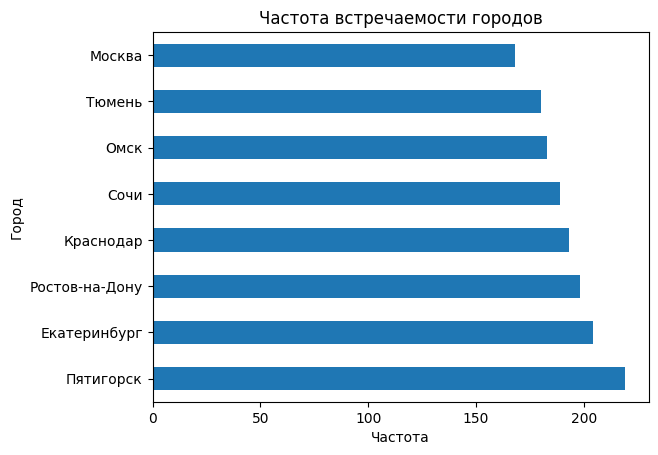

In [23]:
users['city'].value_counts().plot.barh(title='Частота встречаемости городов')
plt.ylabel('Город')
plt.xlabel('Частота')
plt.show()

In [24]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

Чаще всего сервисом пользуются в Пятигорске, реже - в Москве. 

#### Соотношение пользователей с подпиской и без подписки

In [25]:
ultra = users[users['subscription_type'] == 'ultra']['subscription_type'].count()
free = users[users['subscription_type'] == 'free']['subscription_type'].count()

In [26]:
ratio = ultra / free
ratio

0.837125748502994

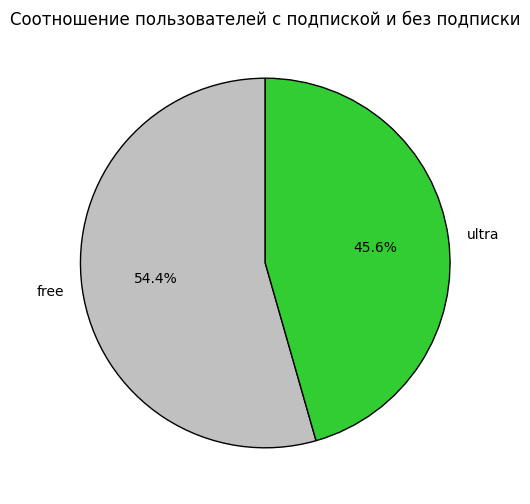

In [27]:
plt.figure(figsize=(10, 6))
users['subscription_type'].value_counts().plot.pie(title='Соотношение пользователей с подпиской и без подписки',
                                                   autopct='%1.1f%%', 
                                                   startangle=90,
                                                   colors = ['#C0C0C0', '#32CD32'],
                                                   wedgeprops={'edgecolor': 'black'})
plt.ylabel('')
plt.show()

Пользователей с подпиской Ultra примерно на 10% меньше, чем пользователей без подписки. Достаточно высокий показатель для платных подписок.

#### Возраст пользователей

In [28]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

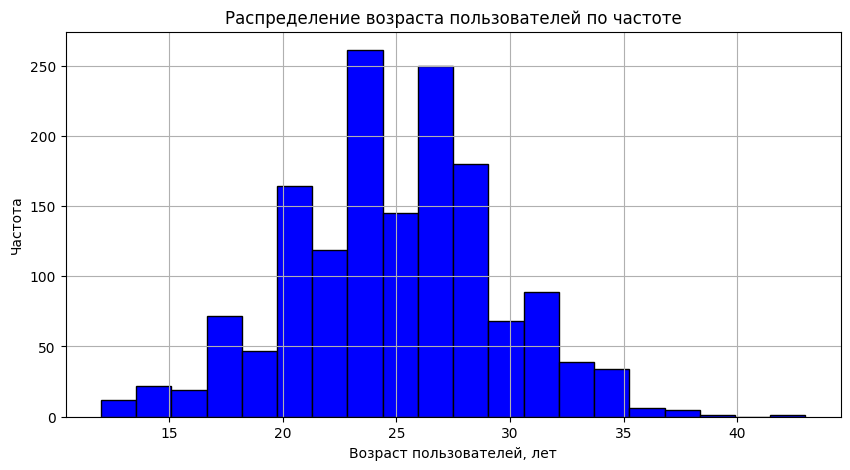

In [29]:
plt.figure(figsize=(10, 5))
users['age'].hist(bins=20,
                  color='blue',
                  edgecolor='black')
plt.title('Распределение возраста пользователей по частоте')
plt.xlabel('Возраст пользователей, лет')
plt.ylabel('Частота')
plt.show()

Среднему пользователю сервиса аренды самокатов 25 лет, самым молодым пользователям - 12 лет, самым взрослым - 43 года.

#### Расстояние, которое пользователь преодолел за одну поездку

In [30]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

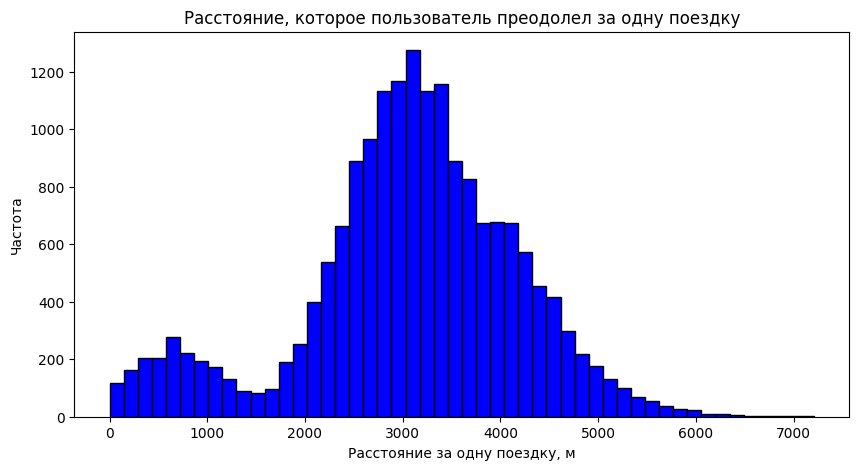

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(rides['distance'], bins=50, color = 'blue', edgecolor = 'black')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние за одну поездку, м')
plt.ylabel('Частота')
plt.show()

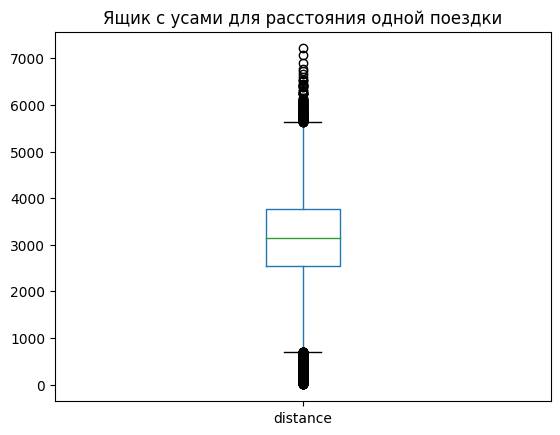

In [32]:
rides['distance'].plot.box(title='Ящик с усами для расстояния одной поездки')
plt.show()

Видно, что пользователи берут самокаты для разных целей. Есть очень короткие поездки (менее метра - похоже на ошибку), есть очень длинные (7211 м). В среднем, пользователь проезжает 3133 метров(для бимодального распределения вообще лучше разделить данные на две группы).
Данные о расстояниях поездок явно делятся примерно на 1500 метров. Группа коротких поездок может быть связана со случайными пользователями (ошибки или испытания нового способа передвижения) или с пользователями с платной подпиской, для которых старт поездки бесплатен. Длинные поездки могут быть связаны с использованием самоката как досуга или средства осмотра города туристами. Также может существовать категория пользователей, которые проезжают небольшие расстояния до метро/остановки автобуса, а есть пользователи, кто едет до конечного пункта. Далее посмотрим, влияет ли на расстояние тип подписки.

#### Продолжительность поездок

In [33]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

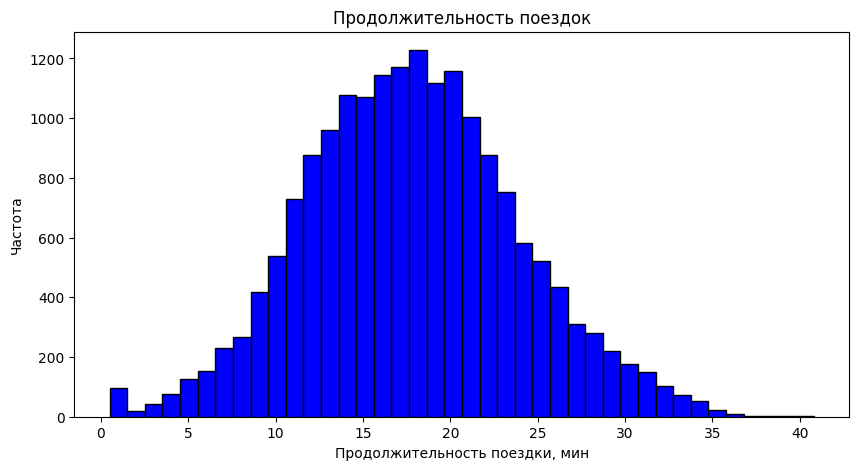

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(rides['duration'],
         bins=40,
         color = 'blue',
         edgecolor = 'black')
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Частота')
plt.show()

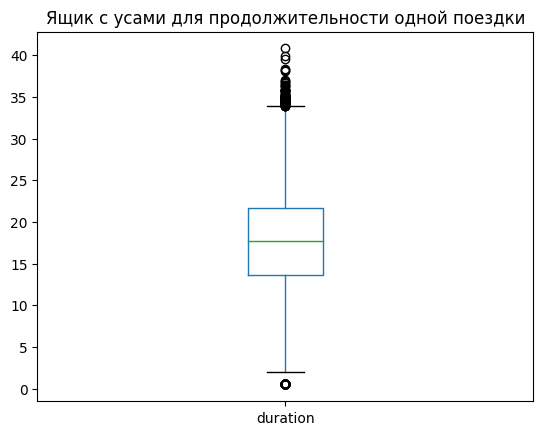

In [35]:
rides['duration'].plot.box(title='Ящик с усами для продолжительности одной поездки')
plt.show()

Очень короткие поездки также похожи на ошибку - менее минуты. Скорее всего, пользователь передумал или не разобрался в работе сервиса и отменил поездку. Максимальная продолжительность поездки составляет около 41 минуты. В среднем, пользователи проводят в поездке около 17.7 минут.

При первичном анализе данных установлено:
- Чаще всего сервисом пользуются в Пятигорске, реже - в Москве.
- Пользователей с подпиской Ultra примерно на 25% меньше, чем пользователей без подписки. Достаточно высокий показатель для платных подписок.
- Среднему пользователю сервиса аренды самокатов 25 лет, самым молодым пользователям - 12 лет, самым взрослым - 43 года.
- Видно, что пользователи берут самокаты для разных целей. Есть очень короткие поездки (менее метра - похоже на ошибку), есть очень длинные (7211 м). В среднем, пользователь проезжает 3133 метров(для бимодального распределения вообще лучше разделить данные на две группы до 1500 м и более 1500).
- Очень короткие поездки также похожи на ошибку - менее минуты. Скорее всего, пользователь передумал или не разобрался в работе сервиса и отменил поездку. Максимальная продолжительность поездки составляет около 41 минуты. В среднем, пользователи проводят в поездке около 17.7 минут.

### Шаг 4. Объединение данных
<a id='merge'></a>

In [36]:
# Объединим информацию о пользователях, поездках и подписках в одну таблицу df.
df = users.merge(
    rides,
    on='user_id')
df = df.merge(
    subscriptions,
    on='subscription_type')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [38]:
# Отдельно создадим таблицы с информацией о пользователях с бесплатной и платной подпиской.
df_free = df[df['subscription_type'] == 'free']
df_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [39]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


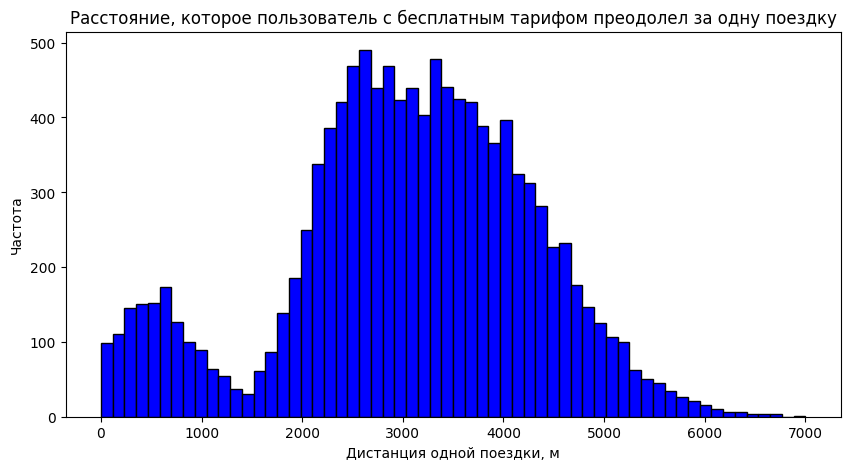

In [40]:
plt.figure(figsize=(10,5))
plt.hist(df_free['distance'],
         bins=60,
         color = 'blue',
         edgecolor = 'black',
         range=[0,7000])
plt.title('Расстояние, которое пользователь с бесплатным тарифом преодолел за одну поездку')
plt.xlabel('Дистанция одной поездки, м')
plt.ylabel('Частота')
plt.show()

In [41]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

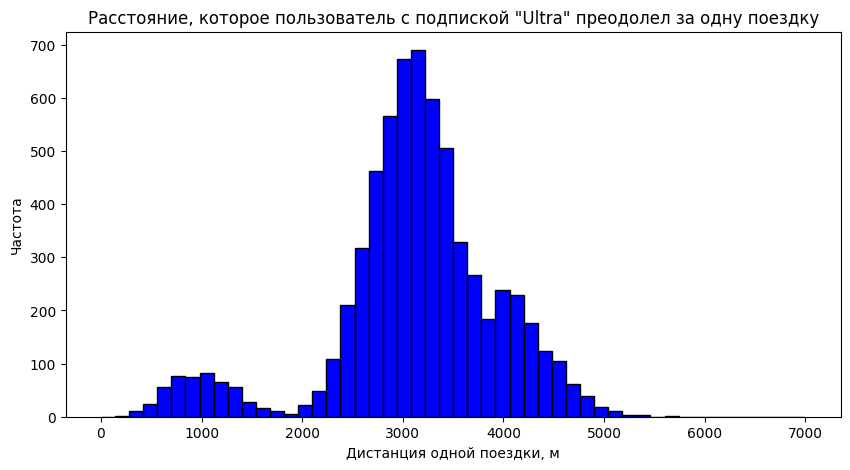

In [42]:
plt.figure(figsize=(10,5))
plt.hist(df_ultra['distance'],
         bins=50,
         color = 'blue',
         edgecolor = 'black',
         range=[0,7000])
plt.title('Расстояние, которое пользователь с подпиской "Ultra" преодолел за одну поездку')
plt.xlabel('Дистанция одной поездки, м')
plt.ylabel('Частота')
plt.show()

In [43]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Распределение дистанций пользователей стремится к нормальному, однако выделяется группа пользователейЮ которые проехали значительно меньшее расстояние (до 1500 м), причем больше таких пользователей среди пользователей без подписки. Возможно, это говорит о том, что часть людей использует сервис или даже самокат впервые, и решили закончить поездку раньше из-за дискомфорта передвижения или пользования сервисом.

Для пользователей с платной подпиской логичнее предположить, что они уже знакомы с сервисом и самокатами, поэтому и приобрели подписку, а короткие поездки связаны с отсутствием оплаты за старт поездки - выгодно брать самокат и на короткие расстояния.

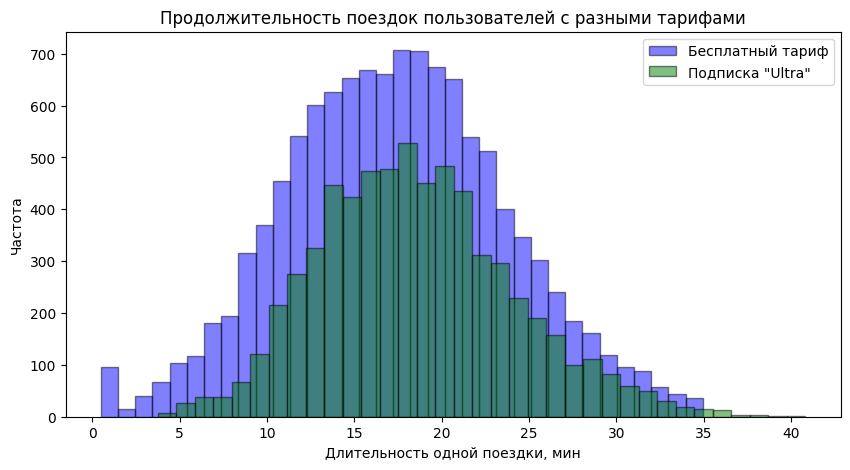

In [44]:
plt.figure(figsize=(10,5))

plt.hist(df_free['duration'],
         bins=35,
         color='blue',
         edgecolor='black',
         alpha=0.5, 
         label='Бесплатный тариф')

plt.hist(df_ultra['duration'],
         bins=35, 
         color='green',
         edgecolor='black',
         alpha=0.5, 
         label='Подписка "Ultra"')

plt.title('Продолжительность поездок пользователей с разными тарифами')
plt.xlabel('Длительность одной поездки, мин')
plt.ylabel('Частота')


plt.legend()
plt.show()

In [45]:
# Проверим аномально короткие поездки у пользователей с бесплатной подпиской 
df.query('duration < 1')[['subscription_type', 'city', 'distance','duration', 'month']]

,subscription_type,city,distance,duration,month
6531,free,Екатеринбург,4196.445201,0.5,8
6570,free,Ростов-на-Дону,4830.824371,0.5,10
6680,free,Москва,4684.004397,0.5,3
6695,free,Краснодар,5215.642710,0.5,2
6768,free,Москва,5197.436649,0.5,2
...,...,...,...,...,...
17004,free,Пятигорск,5531.335845,0.5,1
17242,free,Сочи,6724.932981,0.5,1
17314,free,Екатеринбург,4445.481070,0.5,3
17505,free,Москва,5722.551787,0.5,2


Все аномально короткие поездки совершены за 0.5 минуты на расстояния, превышающие скоростные возможности самокатов. Может быть, произошел сбой программы, время записалось неправильно.
Лучше удалить эти данные (95 строк из 18 тыс - менее 1%)

In [46]:
# Удаление данных с аномально короткими поездками
df = df.loc[df['duration'] > 0.5]
df.query('duration < 1')['duration'].count()

0

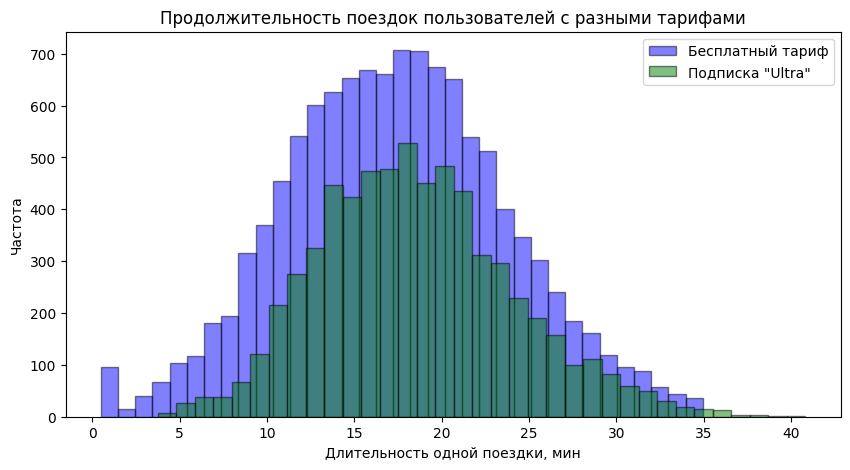

In [47]:
plt.figure(figsize=(10,5))

plt.hist(df_free['duration'],
         bins=35,
         color='blue',
         edgecolor='black',
         alpha=0.5, 
         label='Бесплатный тариф')

plt.hist(df_ultra['duration'],
         bins=35, 
         color='green',
         edgecolor='black',
         alpha=0.5, 
         label='Подписка "Ultra"')

plt.title('Продолжительность поездок пользователей с разными тарифами')
plt.xlabel('Длительность одной поездки, мин')
plt.ylabel('Частота')


plt.legend()
plt.show()

In [48]:
df.query('duration < 3.5')[['subscription_type',  'distance','duration', 'month']].head()

,subscription_type,distance,duration,month
6691,free,23.963062,2.053251,11
6801,free,102.323624,2.292353,9
6850,free,30.473763,3.166221,5
7353,free,568.970941,3.137942,4
7453,free,273.136262,2.744917,2


In [49]:
df['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

In [50]:
df['distance'].describe()

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

После удаления аномально коротких поездок другие короткие поездки выглядят правдоподобнее - пользователи без подписки, проезжают адекватное расстояние за маленькое время. Возможно, самокат не подошел им как средство передвижения.
Средняя продолжительность поездки: 17.71, минимальная: 2.03, максимальная - 40.82 минут.

In [51]:
 if df_free['duration'].median() > df_ultra['duration'].median():
    print('Средняя длительность поездки больше у пользователей с бесплатным тарифоми составляет',
          round(df_free['duration'].median(),2), 'минут.')
else:
    print('Средняя длительность поездки больше у пользователей с подпиской "Ultra" и составляет',
          round(df_ultra['duration'].median(), 2), 'минут.')

Средняя длительность поездки больше у пользователей с подпиской "Ultra" и составляет 18.18 минут.


У пользователей с бесплатным тарифом есть почти нулевые по длительности поездки - 0.5, возможно, связаны с ошибкой учета времени. Удалены 95 строк данных с аномалиями (+ по этим данным не рассчитать выручку).
Средняя длительность поездки больше у пользователей с подпиской "Ultra" - 18.18 минут.

### Шаг 5. Подсчёт выручки
<a id='revenue'></a>

In [52]:
# Округление продолжительности в большую сторону до целого
df['duration'] = np.ceil(df['duration']) 

In [53]:
# Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными
agg_data = df.pivot_table(
    index=['user_id', 'month'],
    values=['distance', 'duration', 'subscription_type'],
    aggfunc={'distance': sum,
             'duration': [sum, len],
             }
)
agg_data.columns = ['sum_distance', 'quantity', 'sum_duration']
agg_data = agg_data.reset_index()
agg_data 

,user_id,month,sum_distance,quantity,sum_duration
0,1,1,7027.511294,2.0,42.0
1,1,4,754.159807,1.0,7.0
2,1,8,6723.470560,2.0,46.0
3,1,10,5809.911100,2.0,32.0
4,1,11,7003.499363,3.0,56.0
...,...,...,...,...,...
11295,1534,6,3409.468534,2.0,26.0
11296,1534,8,7622.453034,2.0,48.0
11297,1534,9,4928.173852,1.0,23.0
11298,1534,11,13350.015305,4.0,78.0


In [54]:
# Добавление столбцов с параметрами для расчета выручки от каждого пользователя за месяц
agg_data_merged = agg_data.merge(
    df[['user_id', 'subscription_type', 'minute_price','start_ride_price', 'subscription_fee']].reset_index(),
    on='user_id',
    how='left')
agg_data_merged

,user_id,month,sum_distance,quantity,sum_duration,index,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2.0,42.0,0,ultra,6,0,199
1,1,1,7027.511294,2.0,42.0,1,ultra,6,0,199
2,1,1,7027.511294,2.0,42.0,2,ultra,6,0,199
3,1,1,7027.511294,2.0,42.0,3,ultra,6,0,199
4,1,1,7027.511294,2.0,42.0,4,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...
142332,1534,12,2371.711192,1.0,16.0,18063,free,8,50,0
142333,1534,12,2371.711192,1.0,16.0,18064,free,8,50,0
142334,1534,12,2371.711192,1.0,16.0,18065,free,8,50,0
142335,1534,12,2371.711192,1.0,16.0,18066,free,8,50,0


In [55]:
agg_data_merged = agg_data_merged.drop_duplicates(subset=['user_id', 'month']).reset_index(drop='True')
agg_data_merged

,user_id,month,sum_distance,quantity,sum_duration,index,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2.0,42.0,0,ultra,6,0,199
1,1,4,754.159807,1.0,7.0,0,ultra,6,0,199
2,1,8,6723.470560,2.0,46.0,0,ultra,6,0,199
3,1,10,5809.911100,2.0,32.0,0,ultra,6,0,199
4,1,11,7003.499363,3.0,56.0,0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,3409.468534,2.0,26.0,18055,free,8,50,0
11296,1534,8,7622.453034,2.0,48.0,18055,free,8,50,0
11297,1534,9,4928.173852,1.0,23.0,18055,free,8,50,0
11298,1534,11,13350.015305,4.0,78.0,18055,free,8,50,0


In [56]:
# Вычислим выручку за месяц от каждого пользователя
agg_data_merged['revenue'] = (
    agg_data_merged['start_ride_price']
    * agg_data_merged['quantity']
    + agg_data_merged['minute_price']
    * agg_data_merged['sum_duration']
    + agg_data_merged['subscription_fee']
)
agg_data_merged

,user_id,month,sum_distance,quantity,sum_duration,index,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2.0,42.0,0,ultra,6,0,199,451.0
1,1,4,754.159807,1.0,7.0,0,ultra,6,0,199,241.0
2,1,8,6723.470560,2.0,46.0,0,ultra,6,0,199,475.0
3,1,10,5809.911100,2.0,32.0,0,ultra,6,0,199,391.0
4,1,11,7003.499363,3.0,56.0,0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...,...
11295,1534,6,3409.468534,2.0,26.0,18055,free,8,50,0,308.0
11296,1534,8,7622.453034,2.0,48.0,18055,free,8,50,0,484.0
11297,1534,9,4928.173852,1.0,23.0,18055,free,8,50,0,234.0
11298,1534,11,13350.015305,4.0,78.0,18055,free,8,50,0,824.0


Создана сводная таблица с данными по каждому пользователю. Также рассчитана выручка за месяц от каждого пользователя в столбце revenue.

### Шаг 6. Проверка гипотез
<a id='hypothesis'></a>

#### Тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза: пользователи с подпиской тратят на поездки столько же времени, как и пользователи без подписки.   
Альтернативная гипотеза: пользователи с платной подпиской тратят больше времени на поездки, чем пользователи без нее.

In [72]:
# Проверим нулевую гипотезу.
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df_ultra['duration'],
                       df_free['duration'],
                       alternative='greater',
                       equal_var=False)


if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу.\nСреднее значение первой генеральной совокупности больше среднего значения второй генеральной совокупности.\nПользователи с платной подпиской тратят больше времени на поездки, чем пользователи без нее. Шанс ошибочно отвергнуть нулевую гипотезу равен {results.pvalue * 100}%.')
else:
    print(f'Не отвергаем нулевую гипотезу. \n Пользователи с подпиской тратят столько же времени, сколько и пользователи без подписки.') 

Отвергаем нулевую гипотезу.
Среднее значение первой генеральной совокупности больше среднего значения второй генеральной совокупности.
Пользователи с платной подпиской тратят больше времени на поездки, чем пользователи без нее. Шанс ошибочно отвергнуть нулевую гипотезу равен 5.675781377128977e-35%.


Так как пользователи с платной подпиской в среднем тратят больше времени на поездки, они могут быть выгоднее для компании.

#### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное с точки зрения износа самоката? 

Нулевая гипотеза: среднее рассстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.    
Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

In [58]:
# Проверим нулевую гипотезу.

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

optimal_distance = 3130 # оптимальное расстояние с точки зрения износа самоката

results = st.ttest_1samp(df_ultra['distance'],
                                  optimal_distance,
                                alternative='greater')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу:  среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров. Шанс ошибочно отвергнуть нулевую гипотезу равен {round(results.pvalue, 2)}.')
else:
    print(f'Не отвергаем нулевую гипотезу. Среднее расстояние пользователей с платной подпиской равно 3130 метров.')

Не отвергаем нулевую гипотезу. Среднее расстояние пользователей с платной подпиской равно 3130 метров.


В результате проверки гипотезы о равенстве среднего расстояния, которое проезжают пользователи с платной подпиской, выявлено, гипотеза не отвергнута. Получается, что пользователи с подпиской проезжают в среднем 3130 метров, что оптимально с точки зрения износа самокатов. Это также подтверждает "выгодность" пользователей с подпиской для компании.

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? 

Нулевая гипотеза: выручка по месяцам от пользователей с подпиской равна выручке от пользователей без подписки.    
Альтернативная гипотеза: Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [71]:
# Проверим нулевую гипотезу.

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

free_subscr = agg_data_merged.query('subscription_type == ["free"]')['revenue']
ulra_subscr = agg_data_merged.query('subscription_type == ["ultra"]')['revenue']

results = st.ttest_ind(ulra_subscr,
                       free_subscr,
                       alternative='greater',
                       equal_var=False)

if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки. Шанс ошибочно отвергнуть нулевую гипотезу равен  {results.pvalue * 100}%.')
else:
    print(f'Не отвергаем нулевую гипотезу. \nВыручка за месяц от пользователей с подпиской такая же, как от пользователей без подписки.')



Отвергаем нулевую гипотезу. Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки. Шанс ошибочно отвергнуть нулевую гипотезу равен  2.4970242872858464e-36%.


Отвергаем нулевую гипотезу. Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки даже при том, что их меньше.
Выгодно будет увеличить количество пользователей с подпиской. 

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**scipy.stats.ttest_rel**: Проверяется гипотеза о равенстве среднего значения генеральной совокупности до и после изменения. Выборки будут парными, так как одна и та же выборка измерялась дважды: до изменения и после.

- Пользователи с платной подпиской в среднем тратят больше времени на поездки, они могут быть выгоднее для компании, если, например, увеличить стоимость минуты поездки.
- В результате проверки гипотезы о равенстве среднего расстояния, которое проезжают пользователи с платной подпиской, выявлено, гипотеза не отвергнута. Получается, что пользователи с подпиской проезжают в среднем 3130 метров, что оптимально с точки зрения износа самокатов. Если бы они проезжали больше, компании пришлось бы закладывать больше средств на амортизацию.
- Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки даже при том, что их меньше на 10%. Значит, выгодно увеличивать долю пользователей с платной подпиской.

### Шаг 7. Распределения
<a id='distribution'></a>

#### Акция с промокодами

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Сначала посмотрим на результаты акции для уже существующих пользователей без платной подписки

In [60]:
# Зададим параметры биномиального распределения (есть два исхода (продление/непродление) у множества независимых испытаний)
p_prolong = 0.1 # Вероятность успеха - вероятность продления подписки
minimum = 100 # Значение-граница - минимальное количество успехов
client_number = len(agg_data_merged.query('subscription_type == "free"'))

Проверим, можно ли аппроксимировать биномиальное распределение нормальным для дальнейших расчетов.

In [61]:
# Проверим условие аппроксимации биномиального распределения нормальным
upper_bound = p_prolong * client_number + 3 * sqrt(p_prolong * client_number * (1 - p_prolong))
lower_bound = p_prolong * client_number - 3 * sqrt(p_prolong * client_number * (1 - p_prolong))

if (0 <= lower_bound <= client_number) and (0 <= upper_bound <= client_number):
    print('Аппроксимацию биномиального распределения нормальным можно использовать.')
else:
    print('Аппроксимация нормальным распределением не подходит.')

Аппроксимацию биномиального распределения нормальным можно использовать.


In [62]:
# Зададим параметры нормального распределения
mu = client_number * p_prolong
sigma = sqrt(p_prolong * client_number * (1 - p_prolong))
distr_norm = st.norm(mu, sigma)
# считаем вероятность получить значение, больше минимума (100 продлений)
probability = 1 - distr_norm.cdf(minimum - 1)
print(f'При рассылке промокодов всем существующим клиентам без платной подписки можно получить минимум 100 продлений\nподписки можно с вероятностью {round(probability * 100, 2)}%.')


При рассылке промокодов всем существующим клиентам без платной подписки можно получить минимум 100 продлений
подписки можно с вероятностью 100.0%.


Найдем минимальное количество промокодов для того, чтобы вероятность не получить 100 подписок была примерно 5%.

In [63]:
# Задаем параметры
p_prolong = 0.1  # Вероятность продления подписки
minimum = 100  # Минимальное количество продлений подписки
confidence_level = 0.95  # Уровень доверия (95%)

# Подбор параметра client_number_success
client_number_success = 0
probability = 0

# Итеративно находим минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5%
while probability < confidence_level:
    client_number_success += 1
    mu = client_number_success * p_prolong
    sigma = sqrt(client_number_success * p_prolong * (1 - p_prolong))
    distr_norm = st.norm(mu, sigma)
    probability = 1 - distr_norm.cdf(minimum - 1)

print(f'Минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5%: {client_number_success}')

Минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5%: 1158


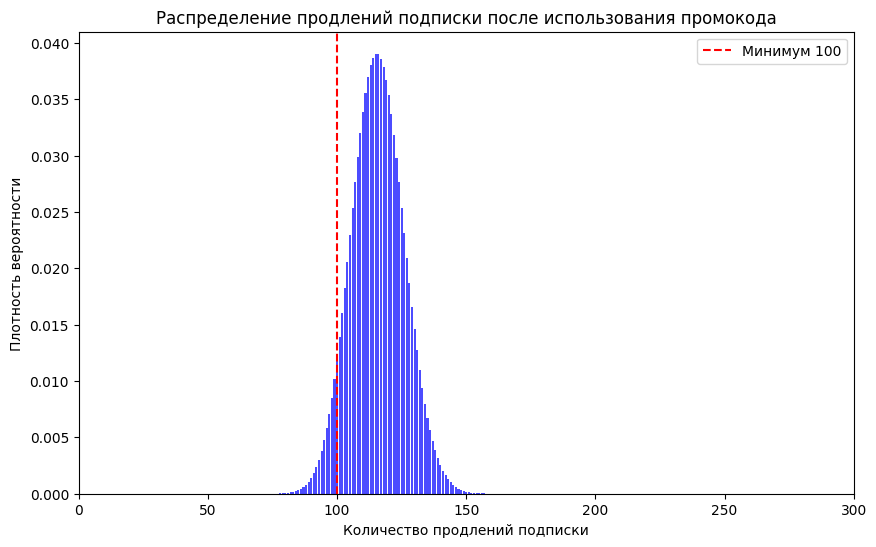

In [64]:
# Построим график биномиального распределения
warnings.filterwarnings("ignore", category=RuntimeWarning)
x = np.arange(0, client_number_success + 1)
binom_distr = st.binom(client_number_success, p_prolong)
pmf = binom_distr.pmf(x)

plt.figure(figsize=(10, 6))
plt.bar(x, pmf, color='blue', alpha=0.7)
plt.title('Распределение продлений подписки после использования промокода')
plt.xlabel('Количество продлений подписки')
plt.ylabel('Плотность вероятности')
plt.xlim(0, 300)
plt.axvline(minimum, color='red', linestyle='--', label=f'Минимум {minimum}')
plt.legend()
plt.show()

Минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5%: 1158.

#### Push-уведомления в мобильном приложении

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации необходимо построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [65]:
# Задаём параметры биномиального распределения
n = 10**6
p = 0.4
maximum = 399500

# Зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# Задаём нормальное распределение
distr_norm_push = st.norm(mu, sigma) 

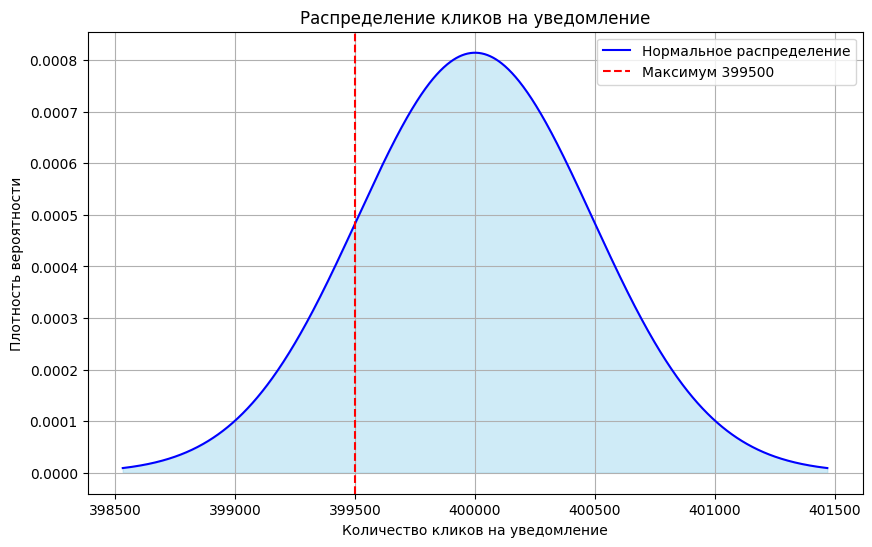

In [66]:
# Создание данных для нормального распределения
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = st.norm.pdf(x, mu, sigma)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение', color='blue')
plt.fill_between(x, y, color='skyblue', alpha=0.4)
plt.title('Распределение кликов на уведомление')
plt.xlabel('Количество кликов на уведомление')
plt.ylabel('Плотность вероятности')
plt.axvline(maximum, color='red', linestyle='--', label=f'Максимум {maximum}')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Считаем вероятность хвоста слева от 399.5 тысяч
probability_open = distr_norm_push.cdf(maximum)
print(f'Вероятность, что уведомление откроют не более 399,5 тыс. пользователей, равна примерно {round(probability_open, 2)* 100}%')

Вероятность, что уведомление откроют не более 399,5 тыс. пользователей, равна примерно 15.0%


### Общий вывод
<a id='conclusion'></a>

В результате выполнения проекта данные о пользователях, поездках пользователей и о подписках сохранены в 3 датафреймах соответственно: users, rides, subscriptions.

Проведена предобработка данных: проверено и подтверждено отсутствие пропусков данных, найдены и устранены полные дубликаты строк.

При первичном анализе данных установлено:

- Чаще всего сервисом пользуются в Пятигорске, реже - в Москве.
- Пользователей с подпиской Ultra примерно на 10% меньше, чем пользователей без подписки. Достаточно высокий показатель для платных подписок.
- Среднему пользователю сервиса аренды самокатов 25 лет, самым молодым пользователям - 12 лет, самым взрослым - 43 года.
- Видно, что пользователи берут самокаты для разных целей. Есть очень короткие поездки (менее метра - похоже на ошибку или случайную активацию поездки), есть очень длинные (7211 м). В среднем, пользователь проезжает 3059.86 метров(для бимодального распределения вообще лучше разделить данные на две группы до 1500 м и более 1500).
- Очень короткие поездки также похожи на ошибку - менее минуты. Скорее всего, произошла ошибка учета времени. Такие данные удалены(95 строк). Средняя продолжительность поездки: 17.71, минимальная: 2.03, максимальная - 40.82 минуты.

Данные из 3 источников объеденены в один датафрейм df. Проанализированы показатели длительности поездки и дистации поездки отдельно для пользователей с платным и бесплатным тарифами:
- У пользователей с бесплатным тарифом есть почти нулевые по длительности поездки - возможно, связанные с ошибкой, случайным заказом и т.д. 
- Средняя длительность поездки больше у пользователей с подпиской "Ultra" - 18.18 минут.

Создана сводная таблица с данными по каждому пользователю agg_data_merged. Также рассчитана выручка за месяц от каждого пользователя в столбце revenue. Это позволило перейти к проверке гипотиз.

Проверены 3 гипотезы:
- Пользователи с платной подпиской в среднем тратят больше времени на поездки, они могут быть выгоднее для компании, если, например, увеличить стоимость минуты поездки.
- В результате проверки гипотезы о равенстве среднего расстояния, которое проезжают пользователи с платной подпиской, выявлено, гипотеза не отвергнута. Получается, что пользователи с подпиской проезжают в среднем 3130 метров, что оптимально с точки зрения износа самокатов. Если бы они проезжали больше, компании пришлось бы закладывать больше средств на амортизацию.
- Выручка за месяц от пользователей с подпиской выше, чем выручка от пользователей без подписки даже при том, что их меньше на 10%. Значит, выгодно увеличивать долю пользователей с платной подпиской.

Пользователи с платной подпиской, в целом, должны быть выгоднее, чем пользователи без подписки.

Для проверки гипотезы о снижении количества обращений в техподдержкудо обновления и после обновления сервиса необходимо использовать метод scipy.stats.ttest_rel: проверяется гипотеза о равенстве среднего значения генеральной совокупности до и после изменения. Выборки будут парными, так как одна и та же выборка измерялась дважды: до изменения и после.

Найдено минимальное количество промокодов на месяц подписки бесплатно, которые нужно разослать для выполнения плана: не менее 100 новых пользователей должны продлить подписку после окончания действия промокода. Минимальное количество промокодов, чтобы вероятность не выполнить план была примерно 5%: 1158.

При рассылке 1 млн. push-уведомлений, вероятность, что уведомление откроет не более 399.5 тысяч пользователей, равна 15%.